In [1]:
import cobra
import thermo_flux
import thermo_flux.tools
import pandas as pd
import numpy as np

import os.path as path

from thermo_flux.io import load_excel as ex
from thermo_flux.io import helper_load as hl

from equilibrator_api import  Q_

from thermo_flux.solver.gurobi import variability_analysis

In [2]:
INPUT_MODEL = "datafiles/model.xlsx"
INPUT_KEGGS = "datafiles/ecoli_kegg_id.csv"
INPUT_REED = "datafiles/reed.csv"
INPUT_INCHI = "datafiles/InChIs.csv"
INPUT_GAMS = "datafiles/model_Ecoli_from-gams.xlsx"
INPUT_EXP_DATA = "datafiles/allPhysioData_formatted_forGSM_20230831.csv"
INPUT_EXP_CONC = "datafiles/allConcRange_20230912.csv"
INPUT_METABOLOMICS = "datafiles/metabolomics-Kochanowski_20230925.csv"

MODEL_NAME = "ecoli"
CONDITIONS = ["WT-Glc_I", "WT-Ace_I"]

INCLUDE_CO2 = True
INCLUDE_O2 = True
ALLOW_OTHER_EXCRETION = False
RELAX_EXP_FLUX_BOUNDS = 2.0

In [3]:
def gen_model(name: str, model_xlsx: str, kegg: str, reed: str, inchi:str, gams: str, output_log: str, add_o2: bool, add_co2: bool, update_thermodynamics=True):
    tmodel = ex.create_thermo_model(name, model_excel=model_xlsx, keggids_csv=kegg, edit_mets={})

    # ADD HYDROXYBENZOATE TRANSPORT & EXCHANGE:
    # Define extracellular orotate:
    hbz_e = cobra.Metabolite(id="4hbz_e", compartment="e")
    hbz_e = thermo_flux.core.metabolite.ThermoMetabolite(hbz_e, model=tmodel)
    hbz_e.annotation = tmodel.metabolites.get_by_id("4hbz_c").annotation  
    tmodel.metabolites.append(hbz_e)

    # Hydroxybenzoate H+ antiporter (aaeB):
    HBZt3 = cobra.Reaction("HBZt3")
    HBZt3.lower_bound = -1000
    HBZt3.upper_bound = 1000
    HBZt3.add_metabolites({tmodel.metabolites.get_by_id("4hbz_e"): +1,
                      tmodel.metabolites.h_e: -1,
                      tmodel.metabolites.get_by_id("4hbz_c"): -1,
                      tmodel.metabolites.h_c: +1})
    HBZt3 = thermo_flux.core.reaction.ThermoReaction(HBZt3, model=tmodel)

    # Exchange:
    EX_4hbz = cobra.Reaction("EX_4hbz")
    EX_4hbz.add_metabolites({tmodel.metabolites.get_by_id("4hbz_e"): -1})
    EX_4hbz = thermo_flux.core.reaction.ThermoReaction(EX_4hbz, model=tmodel)

    tmodel.add_reactions([HBZt3, EX_4hbz])

    # ADD ISOPROPYLMALATE TRANSPORT & EXCHANGE:
    # Define extracellular orotate:
    ipm_e = cobra.Metabolite(id="3c3hmp_e", compartment="e")
    ipm_e = thermo_flux.core.metabolite.ThermoMetabolite(ipm_e, model=tmodel)
    ipm_e.annotation = tmodel.metabolites.get_by_id("3c3hmp_c").annotation  
    tmodel.metabolites.append(ipm_e)

    # Diffusion across the membrane:
    ipm_diff = cobra.Reaction("IPMex")
    ipm_diff.lower_bound = -1000
    ipm_diff.upper_bound = 1000
    ipm_diff.add_metabolites({tmodel.metabolites.get_by_id("3c3hmp_c"): -1,
                            tmodel.metabolites.get_by_id("3c3hmp_e"): +1})
    ipm_diff = thermo_flux.core.reaction.ThermoReaction(ipm_diff, model=tmodel)

    # Exchange:
    EX_3c3hmp = cobra.Reaction("EX_3c3hmp")
    EX_3c3hmp.add_metabolites({tmodel.metabolites.get_by_id("3c3hmp_e"): -1})
    EX_3c3hmp = thermo_flux.core.reaction.ThermoReaction(EX_3c3hmp, model=tmodel)

    tmodel.add_reactions([ipm_diff, EX_3c3hmp])

    # ADD OROTATE TRANSPORT AND EXCHANGE
    # Define extracellular orotate:
    oro_e = cobra.Metabolite(id="orot_e", compartment="e")
    oro_e = thermo_flux.core.metabolite.ThermoMetabolite(oro_e, model=tmodel)
    oro_e.annotation = tmodel.metabolites.orot_c.annotation  
    tmodel.metabolites.append(oro_e)

    # Diffusion across the membrane:
    oro_diff = cobra.Reaction("OROTex")
    oro_diff.lower_bound = -1000
    oro_diff.upper_bound = 1000
    oro_diff.add_metabolites({tmodel.metabolites.orot_c: -1,
                            tmodel.metabolites.orot_e: +1})
    oro_diff = thermo_flux.core.reaction.ThermoReaction(oro_diff, model=tmodel)

    # Dicarboxylate/H+ symporter (dctA):
    dcta = cobra.Reaction("DCTA")
    dcta.lower_bound = -1000
    dcta.upper_bound = 0
    dcta.add_metabolites({tmodel.metabolites.orot_e: +1,
                        tmodel.metabolites.h_e: +1,
                        tmodel.metabolites.orot_c: -1,
                        tmodel.metabolites.h_c: -1})
    dcta = thermo_flux.core.reaction.ThermoReaction(dcta, model=tmodel)

    # Exchange:
    EX_oro = cobra.Reaction("EX_oro")
    EX_oro.add_metabolites({tmodel.metabolites.orot_e: -1})
    EX_oro = thermo_flux.core.reaction.ThermoReaction(EX_oro, model=tmodel)

    tmodel.add_reactions([oro_diff, dcta, EX_oro])

    # Define thermodynamic parameters
    tmodel.pH = {"c": Q_(7.6), "e": Q_(7)} #pH
    tmodel.I = {"c": Q_(0.25,'M'), "e": Q_(0.25,'M')} #ionic stength
    tmodel.phi = {'ce':Q_(0.15,'V')} #membrane potential ‘ce’ represents the voltage between compartment ‘c’ and compartment 'e’ defined as Phic - Phie
    tmodel.pMg = {'e': Q_(3), 'c': Q_(3)}

    # Update metabolite annotations with the IDs from KEGG
    for met in tmodel.metabolites:
        met.annotation["bigg.metabolite"] = met.id[:-2]

    # Update the inchi strings of some unknown metabolites
    df = pd.read_csv(reed, header=None).set_index(0)

    unknown_mets = []
    for met in tmodel.metabolites:
        if met.id[:-2] in df.index:
            met.annotation['InChI'] = df.loc[met.id[:-2]].iloc[1]
            unknown_mets.append(met)

    for met in tmodel.metabolites:
        if ('kegg' in met.annotation):
            if (met.annotation['kegg'] in df.index):
            
                inchi = df.loc[met.annotation['kegg']].iloc[0]

                if type(inchi) is str:
                    met.annotation['InChI'] = df.loc[met.annotation['kegg']].iloc[0]
                    unknown_mets.append(met)

    # Additional data from excel spredsheet needs to be imported for some compounds with unknown structure
    sheets = ex.read_excelfile(model_xlsx)

    for met in tmodel.metabolites:
        if met.id[:-2] in sheets['Metabolites']['Unnamed: 0'].values:

            common_name = sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 11'].values
            protons = sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 9'].values
            charge =  sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 8'].values
            formula =  sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 12'].values

            met.formula = 'H'+str(protons[0])

            if len(common_name) > 0:
                met.notes['common name'] = common_name[0]
                met.charge = charge[0]
            else:
                met.notes['common name'] = ''

    # Hydrogenase reactions are missing protons
    for rxn in tmodel.reactions:
        if 'HYD' in rxn.id:
            if 'ATP' not in rxn.id:
                rxn.add_metabolites({tmodel.metabolites.h_e:2,
                                    tmodel.metabolites.h_c:-2})

    # Remove duplicate/additional reactions
    RXNS_TO_REMOVE = []
    for rxn in tmodel.reactions:
        if rxn.id.endswith("_add"):
            RXNS_TO_REMOVE.append(rxn)   
    tmodel.remove_reactions(RXNS_TO_REMOVE)

    # FDH reactions are missing protons and water is on wrong side of membrane 
    tmodel.reactions.FDH2.add_metabolites({tmodel.metabolites.h_e:2,
                                        tmodel.metabolites.h_c:-2,
                                        tmodel.metabolites.h2o_c:1,
                                        tmodel.metabolites.h2o_e:-1})
    tmodel.reactions.FDH3.add_metabolites({tmodel.metabolites.h_e:2,
                                        tmodel.metabolites.h_c:-2,
                                        tmodel.metabolites.h2o_c:1,
                                        tmodel.metabolites.h2o_e:-1})

    # Missing transporterd metabolites
    tmodel.reactions.TMAOR1e.transported_mets = {tmodel.metabolites.tmao_e: -1}
    tmodel.reactions.TMAOR2e.transported_mets = {tmodel.metabolites.tmao_e: -1}
    tmodel.reactions.GLCDe.transported_mets = {tmodel.metabolites.get_by_id('glc-D_e'): -1}

    #D MSOR1e protons are incorrect - this resets the reaction to the bigg version 
    tmodel.reactions.DMSOR1e.add_metabolites({tmodel.metabolites.h_e:-2,
                                            tmodel.metabolites.h_c:2 })
    tmodel.reactions.DMSOR2e.add_metabolites({tmodel.metabolites.h_e:-2,
                                            tmodel.metabolites.h_c:2 })

    tmodel.reactions.DMSOR1e.transported_mets = {tmodel.metabolites.dmso_e: -1}
    tmodel.reactions.DMSOR2e.transported_mets = {tmodel.metabolites.dmso_e: -1}

    tmodel.reactions.SHCHF.add_metabolites({tmodel.metabolites.scl_c:-1,
                                            tmodel.metabolites.srch_c:1})

    # Sirohydrochlorin dehydrogenase is incorrectly defined in model 
    tmodel.reactions.SHCHD2.add_metabolites({tmodel.metabolites.scl_c:2,
                                            tmodel.metabolites.srch_c:-2})

    #Update srch metabolite name
    tmodel.metabolites.srch_c.annotation = {'bigg.metabolite': 'dscl'}

    # Specific reaction that invovled chemcial transformation as part of transport
    tmodel.reactions.NMNt7.transported_mets = {tmodel.metabolites.nmn_e:-1}

    # PTS mechanism 
    for rxn in tmodel.reactions:
        if 'pts' in rxn.id:
            rxn.transported_mets = {met:stoich for met, stoich in rxn.metabolites.items() if met.compartment == 'e'}

    #in imported model any charge metabolite represents a free cation that is transported 
    for rxn in tmodel.reactions:
        if 'biomass' not in rxn.id:   # ignore biomass reaction 
            
            transported_charge = {}
            for met, stoich in rxn.metabolites.items():
                if (met in tmodel.charge_dict.values()):
                    transported_charge[met.compartment] = stoich
            
            if len(transported_charge) != 0:
                rxn.transported_charge = transported_charge

    # Load default concentration bounds from the GAMS model:
    df_conc = hl.excel_to_df(gams)["ConcLimits"]

    # Rearrange data for easier use:
    df_conc = df_conc.reset_index()
    df_conc["met"] = df_conc["dim1"] + "_"+ df_conc["dim2"]
    df_conc = df_conc.pivot_table(columns="dim3", values="Value", index="met")

    # Change upper and lower concentration bounds the values in the dataframe df_conc (taken from GAMS)
    # (values are in mM)
    for met, row in df_conc.iterrows():
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(row["up"], "mM")
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(row["lo"], "mM")

    # Find correct biomass reaction
    biomass_rxns = [r for r in tmodel.reactions if 'biomass' in r.id.lower()]
    for r in biomass_rxns:
        print(r.id, ":", r.reaction[:80])

    # Correct reaction is 'biomass'
    # Define the protons in biomass 
    tmodel.metabolites.biomass_c.formula = 'H74'  # estimated http://www.ncbi.nlm.nih.gov/pubmed/20506321
    tmodel.metabolites.biomass_e.formula = 'H74'

    # Assign biomass
    tmodel.metabolites.biomass_c.biomass = True
    tmodel.metabolites.biomass_e.biomass = True

    tmodel.reactions.biomass.add_metabolites({tmodel.metabolites.atp_c: -31.2622,
                                                tmodel.metabolites.h2o_c: -31.2622,
                                                tmodel.metabolites.adp_c: +31.2622,
                                                tmodel.metabolites.pi_c:  +31.2622})


    # Define biomass formation energy: dfG0(biomass) [kJ gCDW-1] = -2.692234848 fom Battley 1991
    base_dfg = (Q_(-2.692234848, "kJ/mol") * 1000) # values in J/gDW 

    tmodel.metabolites.biomass_c.dfG0 = base_dfg
    tmodel.metabolites.biomass_e.dfG0 = base_dfg

    tmodel.reactions.biomass_ce.ignore_snd = True

    if update_thermodynamics:
        for rxn in tmodel.reactions:
            thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)

        for met in tmodel.metabolites:
            if met.id in ['charge_c', 'charge_m', 'charge_e']:
                met.ignore_conc = True
        tmodel.update_thermo_info(fit_unknown_dfG0=True)

    return tmodel

In [4]:
def apply_metabolome_physio_data(tmodel, condition :str, input_exp: str, input_conc: str, input_metabolomics: str, input_gams: str, relax_flux_bounds, include_CO2: bool, include_O2: bool, allow_other_excr: bool, output_log: str, open_exchanges=False, flux_limit = 100):
    "Apply metabolome and physiological data to base stoichiometric-thermodynamic ecoli model"
    df_conc = hl.excel_to_df(input_gams)["ConcLimits"]

    # Rearrange data for easier use:
    df_conc = df_conc.reset_index()
    df_conc["met"] = df_conc["dim1"] + "_"+ df_conc["dim2"]
    df_conc = df_conc.pivot_table(columns="dim3", values="Value", index="met")

    # Import experimental data:
    reg_data = pd.read_csv(input_exp)

    reg_data.set_index(["cond", "rxn"], inplace=True) 
    reg_data.head()

    # Store gas fluxes:
    reg_data_gas = reg_data.swaplevel().copy()
    reg_data_gas = reg_data_gas.loc[["EX_co2", "EX_o2"]]
    reg_data_gas = reg_data_gas.swaplevel()
    reg_data_gas

    if include_CO2 is False:
        reg_data_no_gas = reg_data.swaplevel().copy()
        reg_data_no_gas = reg_data_no_gas.drop(["EX_co2"])
        reg_data_no_gas = reg_data_no_gas.swaplevel()
        reg_data = reg_data_no_gas
        
        
    if include_O2 is False:
        reg_data_no_gas = reg_data.swaplevel().copy()
        reg_data_no_gas = reg_data_no_gas.drop(["EX_o2"]) 
        reg_data_no_gas = reg_data_no_gas.swaplevel()
        reg_data = reg_data_no_gas

    # Set metabolite concentrations to the values in the GAMS model:   
    for met, row in df_conc.iterrows():
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(row["up"], "mM")
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(row["lo"], "mM")
        
    # Import experimental data:
    conc_data = pd.read_csv(input_conc)

    conc_data.set_index(["cond", "met"], inplace=True) 
    conc_data.head()

    available_conditions = ["WT-Glc_I", "WT-Gal_I", "WT-Fruc_I", "WT-Mann_I", "dptsG-Glc_I", "WT-Ace_I", "WT-Succ_I", "WT-Fum_I", "WT-Glyc_I", "WT-Pyr_I", "WT-GlyCAA_II"]
    volume_data = pd.DataFrame({cond: {"c": 1.0} for cond in available_conditions} ).T #specify the volume fractions for each condition
    volume_data.head()

    # Import experimental data:
    met_data = pd.read_csv(input_metabolomics)
    met_data.set_index(["cond", "met"], inplace=True) 
    met_data.head()

    conds_with_data = list(met_data.reset_index().cond.unique())
    missing_conds = [cond for cond in available_conditions if cond not in conds_with_data]

    df_missing = pd.DataFrame({"cond": missing_conds, 
                            "met": "g6p",
                            "mean": np.nan, 
                            "sd": np.nan, }).set_index(["cond", "met"])

    # Apply metabolome data
    met_data = pd.concat([met_data, df_missing])
    met_data_all=pd.read_csv(input_metabolomics, index_col=(0,1))

    df_bounds=thermo_flux.solver.gurobi.calc_conc_bounds(tmodel,[condition],met_data_all,conc_units='mM')
    df_bounds_cond=df_bounds.loc[condition]
    for met_id,row in df_bounds_cond.iterrows():
        tmodel.metabolites.get_by_id(met_id).upper_bound=Q_(row['ub'],'M')
        tmodel.metabolites.get_by_id(met_id).lower_bound=Q_(row['lb'],'M')
        met = tmodel.metabolites.get_by_id(met_id)
        print(met.lower_bound, met.upper_bound)

    exchanges = [rxn.id for rxn in tmodel.exchanges]

    exchanges_to_relax = ["EX_C", "EX_h", "EX_h2o", "EX_k", "EX_nh3", "EX_pi", "EX_so4"]

    if include_CO2 is False:
        exchanges_to_relax += ["EX_co2"]
        
    if include_O2 is False:
        exchanges_to_relax += ["EX_o2"]

    if allow_other_excr is True:
        upper_bound_exchanges = 100
    else:
        upper_bound_exchanges = 0

    # Reset all flux bounds to +- flux limit (default -100 / 100):
    for rxn in tmodel.reactions:
        tmodel.reactions.get_by_id(rxn.id).lower_bound = -flux_limit
        tmodel.reactions.get_by_id(rxn.id).upper_bound = flux_limit
    
    # Add non-growth associate ATP maintenance cost:
    tmodel.reactions.ATPHYD.lower_bound = 3.15

    # Fix exchange reaction directions:
    for rxn in exchanges:
        tmodel.reactions.get_by_id(rxn).lower_bound = 0
        tmodel.reactions.get_by_id(rxn).upper_bound = upper_bound_exchanges
  
    # Relax essential exchanges:
    for rxn_rel in exchanges_to_relax:
        tmodel.reactions.get_by_id(rxn_rel).lower_bound = -flux_limit
        tmodel.reactions.get_by_id(rxn_rel).upper_bound = +flux_limit

    # Fix flux for the measured exchange reactions:
    for rxn, row in reg_data.loc[condition].iterrows():
        tmodel.reactions.get_by_id(rxn).lower_bound = -flux_limit
        tmodel.reactions.get_by_id(rxn).upper_bound = flux_limit

        if not open_exchanges:
            tmodel.reactions.get_by_id(rxn).lower_bound = row["mean"] - relax_flux_bounds * row["sd"]
            tmodel.reactions.get_by_id(rxn).upper_bound = row["mean"] + relax_flux_bounds * row["sd"]

    if condition.startswith("dptsG-Glc"):
        tmodel.reactions.GLCpts.lower_bound = 0
        tmodel.reactions.GLCpts.upper_bound = 0
        
    # Fix concentration for the measured extracellular metabolites:
    for met, row in conc_data.loc[condition].iterrows():
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(1e-9, "M")
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(100, "M")
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(row["conc_M_min"], "M")
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(row["conc_M_max"], "M")

    for met_id, row in df_bounds_cond.iterrows():
        print(f"model: {tmodel.metabolites.get_by_id(met_id).lower_bound}, {tmodel.metabolites.get_by_id(met_id).upper_bound}, metabolome: {row['lb']}, {row['ub']}")
        is_same = abs(tmodel.metabolites.get_by_id(met_id).lower_bound.m - Q_(row['lb'],'M').m) < 0.0000001 and abs(tmodel.metabolites.get_by_id(met_id).upper_bound.m - Q_(row['ub'],'M').m) < 0.0000001
        print(f"Metabolome data applied: {is_same}")
        
    #Normalize reaction fluxes to native floats otherwise SBML will error out when exporting
    for r in tmodel.reactions:
        r.lower_bound = float(r.lower_bound)
        r.upper_bound = float(r.upper_bound)

    return tmodel

In [5]:
def remove_orphan_metabolites(model):
    """
    Cleanup helper function that removes metabolites from the model that do not participate in any reaction
    """

    linked_metabolites = set()
    for rxn in model.reactions:
        for met in rxn.metabolites:
            linked_metabolites.add(met)
            
    all_metabolites = set(model.metabolites)
    orphan_metabolites = list(all_metabolites - linked_metabolites)
    
    orphan_ids = [m.id for m in orphan_metabolites]
    
    if orphan_metabolites:
        print(f"\nRemoving {len(orphan_metabolites)} orphan metabolites:")
        print(f"Orphaned IDs: {', '.join(orphan_ids)}")
        
        model.remove_metabolites(orphan_metabolites)
        
    else:
        print("\nNo orphan metabolites found. ")
        
    return len(orphan_metabolites)

In [6]:
def apply_met_tva(tmodel, met_tva_file):
    "Applies metabolite TVA results to the given model. Note that metaboltite indices need to 100% match."
    bounds_dict = dict()
    with open(met_tva_file, "r") as f:
        for line in f:
            clean_line = line.strip()
            if not clean_line:
                print(f"Skipping line {clean_line}")
                continue
            try:
                index_str, bounds_str = clean_line.split(':', 1)
                index = int(index_str.strip())

                cleaned_bounds_str = bounds_str.strip().strip('[] ')
                lower_str, upper_str = cleaned_bounds_str.split(',')

                lower = float(lower_str.strip())
                upper = float(upper_str.strip())

                linear_lower = np.exp(lower) * 1e3 # From molar conc back to millimolar
                linear_upper = np.exp(upper) * 1e3 # Same
                
                bounds_dict[index] = [linear_lower, linear_upper]
            except ValueError as e:
                print(f"Skipping line due to parsing error: '{line.strip()}' - Error: {e}")
            except Exception as e:
                print(f"unexpected error occurred while processing line: '{line.strip()}' - Error: {e}") 
    
    for met in tmodel.metabolites:
        met_index = tmodel.metabolites.index(met)

        if met_index not in bounds_dict:
            print(f"Skipped metabolite {met.id} as it was not found in TVA data.")
            continue

        cur_lower, cur_upper = met.lower_bound, met.upper_bound
        new_lower, new_upper = bounds_dict[met_index][0], bounds_dict[met_index][1]

        # Fix for floating point errors
        # Sometimes the upper bound can, for example, be 0.99999999 while the lower bound is 1.000000002
        # In this case both are equal, however floating point precision causes cobra to see the upper bound as smaller than the lower bound
        difference = abs(new_upper - new_lower)
        if difference < 1e-6:
            new_lower = new_upper

        met.upper_bound = Q_(new_upper, "millimolar")
        met.lower_bound = Q_(new_lower, "millimolar")

        print(f"Metabolite {met.id} - Old: {cur_lower}, {cur_upper} | New: {met.lower_bound, met.upper_bound}")

In [7]:
def add_rq_constraint(tmodel, condition, phys_data):
    "Add respiratory constraint from physiological data"
    reg_data = pd.read_csv(phys_data)

    reg_data.set_index(["cond", "rxn"], inplace=True) 

    reg_data_gas = reg_data.swaplevel().copy()
    reg_data_gas = reg_data_gas.loc[["EX_co2", "EX_o2"]]
    reg_data_gas = reg_data_gas.swaplevel()

    data_gas = reg_data_gas.loc[condition]
    vo2, vo2_err = data_gas.loc["EX_o2"]
    vco2, vco2_err = data_gas.loc["EX_co2"]
    rq = - vco2 / vo2
    rq_err = rq * np.sqrt( (vo2_err / vo2)**2 + (vco2_err / vco2)**2)
    print(f">>>>>> RQ: {rq :.2} (vCO2 = {vco2 :.3} / vO2 = {vo2 :.3}) ERR: {rq_err}")

    rq_lb = rq - abs(6 * rq_err)
    rq_ub = rq + abs(6 * rq_err)

    mrq = tmodel.m.addMVar(lb=rq_lb, ub=rq_ub, shape=(1,1), name="RQ") 
    tmodel.mvars["rq"] = mrq
    
    idx_o2 = tmodel.reactions.index("EX_o2")
    idx_co2 = tmodel.reactions.index("EX_co2")
    tmodel.m.addConstr(tmodel.mvars["v"][0, idx_co2] == (-mrq)*tmodel.mvars["v"][0, idx_o2], name="enforce_RQ")
    tmodel.m.update()

In [8]:
import pta
from scipy.stats import norm

def conc_to_logdist(lower_bound, upper_bound, frac_of_area = 0.95):
    
    if lower_bound <= 0 or upper_bound <= 0:
        raise ValueError("Concentration bounds must be positive")
    if  lower_bound > upper_bound:
        raise ValueError("Lower bound cannot be higher than upper bound")
    if frac_of_area <= 0.0 or frac_of_area > 1.0:
        raise ValueError("Fraction of area must be between 0.0 and 1.0")
    
    # Linear to ln
    ln_lower = np.log(lower_bound)
    ln_upper = np.log(upper_bound)

    # Standard deviations based on frac_of_area
    beta = (1.0 - frac_of_area) / 2.0 # Area per tail
    Z = norm.ppf(1.0 - beta) # About 1.96 for frac = 0.95

    log_mean = (ln_lower + ln_upper) /  2.0
    log_std = (ln_upper - ln_lower) / (2.0 * Z) # Distance of bounds divided by total number of standard deviations to get a std value

    log_dist = pta.LogNormalDistribution(log_mean=log_mean, log_std=log_std)

    return log_dist

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [9]:
def prepare_tfs_files(tmodel, name, condition, out_folder):
    out_path_base = f"{out_folder}{path.sep}{name}_{condition}"
    
    cobra.io.write_sbml_model(tmodel, f"{out_path_base}.sbml")

    drg0_prime_mean = pd.Series(np.array([r.drG0prime.m + r.drGtransport.m for r in tmodel.reactions]), index = [r.id for r in tmodel.reactions])

    log_dists = [conc_to_logdist(m.lower_bound.to("molar").m, m.upper_bound.to("molar").m, frac_of_area=0.95) for m in tmodel.metabolites]
    conc_log_means = [x.log_mean for x in log_dists]
    conc_log_cov = [np.square(x.log_std) for x in log_dists]

    m_indices = [tmodel.metabolites.index(m) for m in tmodel.metabolites]

    m_names = [m.id for m in tmodel.metabolites]
    bounds_m = []

    for m in tmodel.metabolites:
        bounds_m.append((m.lower_bound.m, m.upper_bound.m))

    conc_bounds_df = pd.DataFrame(data=bounds_m,index=m_names, columns=['lb', 'ub'])
    conc_bounds_df.to_csv(f"{out_path_base}_lcb.csv")

    drg0_cov_sqrt_df = pd.DataFrame(tmodel._drG0_cov_sqrt)

    drg0_prime_mean.to_csv(f"{out_path_base}_drg0pm.csv")
    drg0_cov_sqrt_df.to_csv(f"{out_path_base}_drg0cs.csv")

    log_mean_df = pd.DataFrame(data=np.array(conc_log_means), index=m_indices, columns=['0'])
    log_cov_df = pd.DataFrame(data=np.array(conc_log_cov), index=m_indices, columns=['0'])

    log_mean_df.to_csv(f"{out_path_base}_lcm.csv")
    log_cov_df.to_csv(f"{out_path_base}_lcv.csv")

In [10]:
import importlib
import tfs_scripts.main
import tfs_scripts.preprocess
import glob

importlib.reload(tfs_scripts.pmo_mod)
importlib.reload(tfs_scripts.preprocess)
importlib.reload(tfs_scripts.main)

def create_tfs_model(tfs_dir):

    tfs_files_dir = glob.glob(f"{tfs_dir}/*.*")

    model_file = [x for x in tfs_files_dir if x.endswith(".sbml")][0].strip()
    #vbounds = [x for x in tfs_files_dir if x.endswith("vbounds.csv")][0].strip() # Bounds are already applied to loaded model
    lcv = [x for x in tfs_files_dir if x.endswith("lcv.csv")][0].strip()
    lcm = [x for x in tfs_files_dir if x.endswith("lcm.csv")][0].strip()
    lcb = [x for x in tfs_files_dir if x.endswith("lcb.csv")][0].strip()
    drg0pm = [x for x in tfs_files_dir if x.endswith("drg0pm.csv")][0].strip()
    drg0cs = [x for x in tfs_files_dir if x.endswith("drg0cs.csv")][0].strip()

    tfs_model = tfs_scripts.main.main(model_file, None, lcm, lcv, lcb, drg0pm, drg0cs)

    return tfs_model

In [11]:
def clean_tfva_bounds(lb, ub, tol=1e-7):
    """
    Cleans numerical noise from TFVA bounds to improve solver stability.
    """
    old_lb = lb
    old_ub = ub
    if abs(lb) < tol: lb = 0.0
    if abs(ub) < tol: ub = 0.0
    
    if abs(lb - round(lb)) < tol: lb = round(lb, 8)
    if abs(ub - round(ub)) < tol: ub = round(ub, 8)
    
    if abs(ub - lb) < tol:
        avg = (lb + ub) / 2
        lb, ub = avg, avg

    if lb > ub:
        lb = ub 
    
    print(f"Before/after: {old_lb}, {old_ub} ---> {lb}, {ub}")

    return lb, ub

In [12]:
def apply_tfva_bounds(tmodel, bounds_file):
    df = pd.read_csv(bounds_file)
    #df.set_index("rxn", inplace=True)

    for row in df.itertuples():
        print(row)
        rxn_id = row.rxn
        lb = row.lb
        ub = row.ub

        print(f"{rxn_id}: {tmodel.reactions.get_by_id(rxn_id).lower_bound}, {tmodel.reactions.get_by_id(rxn_id).upper_bound} ---->  {lb}, {ub}")

        lb_clean, ub_clean = clean_tfva_bounds(lb, ub)

        tmodel.reactions.get_by_id(rxn_id).upper_bound = ub_clean
        tmodel.reactions.get_by_id(rxn_id).lower_bound = lb_clean
        



In [13]:
from cobra.flux_analysis import find_blocked_reactions

def setup_model(condition, mets_tva=None):
    "Setup the ecoli model given a condition for physiological data"
    tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, "", True, True)
    tmodel = apply_metabolome_physio_data(tmodel, condition, INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, allow_other_excr=False, output_log="", flux_limit=100)

    blocked = find_blocked_reactions(tmodel, open_exchanges=False, processes=1)

    tmodel.remove_reactions(blocked, remove_orphans=True)
    remove_orphan_metabolites(tmodel)

    for rxn in tmodel.reactions:
        thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)
    tmodel.update_thermo_info(fit_unknown_dfG0=True)

    #Set co2/o2 fluxes in correct directions
    tmodel.reactions.EX_co2.lower_bound = 0.0
    tmodel.reactions.EX_co2.upper_bound = 100.0
    
    tmodel.reactions.EX_o2.lower_bound = -100.0
    tmodel.reactions.EX_o2.upper_bound = 0.0

    # Apply results from metabolite TVA if present
    if mets_tva is not None:
        apply_met_tva(tmodel, mets_tva)
    
    return tmodel

In [14]:
# Recreate model with met TVA applied
tmodel_glc = setup_model(CONDITIONS[0], "results/ecoli_WT_Glc_mets_objval.txt")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' c

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

In [15]:
apply_tfva_bounds(tmodel_glc, "results/bounds/complete_ecoli_WT_Glc_tfva.csv")

blocked = find_blocked_reactions(tmodel_glc, open_exchanges=False, processes=1)

tmodel_glc.remove_reactions(blocked, remove_orphans=True)
remove_orphan_metabolites(tmodel_glc)

tmodel_glc.update_thermo_info(fit_unknown_dfG0=True)

Pandas(Index=0, _1=0, rxn='2DGLCNRx', lb=-100.0, ub=100.0)
2DGLCNRx: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Pandas(Index=1, _1=1, rxn='2DGLCNRy', lb=-100.0, ub=100.0)
2DGLCNRy: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Pandas(Index=2, _1=2, rxn='2DGULRx', lb=-100.0, ub=100.0)
2DGULRx: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Pandas(Index=3, _1=3, rxn='2DGULRy', lb=-100.0, ub=100.0)
2DGULRy: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Pandas(Index=4, _1=4, rxn='A5PISO', lb=0.0281752540556174, ub=0.0294789519508729)
A5PISO: -100.0, 100.0 ---->  0.0281752540556174, 0.0294789519508729
Before/after: 0.0281752540556174, 0.0294789519508729 ---> 0.0281752540556174, 0.0294789519508729
Pandas(Index=5, _1=5, rxn='AACPS1', lb=-99.99436494918882, ub=100.0)
AACPS1: -100.0, 100.0 ---->  -99.99436494918882, 100.0
Before/after: -99.99436494918

In [16]:
prepare_tfs_files(tmodel_glc, "ecoli", "WT_Glc", "results/tfs/WT_Glc/")

In [17]:
importlib.reload(tfs_scripts.preprocess)
importlib.reload(tfs_scripts.pmo_mod)
importlib.reload(tfs_scripts.main)

tfs_model_glc = create_tfs_model("results/tfs/WT_Glc")


ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


2DGLCNRx -100.0 100.0
2DGLCNRy -100.0 100.0
2DGULRx -100.0 100.0
2DGULRy -100.0 100.0
A5PISO 0.0281752540556174 0.0294789519508729
AACPS1 -99.9943649491888 100.0
AACPS2 -10.0 9.99049303799592
AACPS3 -100.0 100.0
AACPS4 -14.0 13.9866902531943
AACPS5 -100.0 99.9049303799592
ABTA -100.0 100.0
ABUTD -100.0 99.9705210480494
ACALDi -100.0 100.0
ACCOACr -100.0 100.0
ACCOAL -100.0 100.0
ACGK -100.0 100.0
ACGS -100.0 100.0
ACHBS 0.185151669509935 0.193718827105343
ACKr -100.0 100.0
ACLS 0.556836266818067 0.58260165184132
ACOATA -100.0 100.0
ACODA -100.0 100.0
ACONT -100.0 100.0
ACOTA -100.0 100.0
ACS -100.0 100.0
ADA 0.0 98.1601023355149
ADCL 0.0335419691141272 0.0350939904176281
ADCS 0.0335419691141254 0.0350939904176281
ADD 0.0 98.1601062726318
ADK1 -100.0 100.0
ADK3 -100.0 100.0
ADMDCr 0.0046958756759778 0.0049131586584678
ADNK1 -100.0 100.0
ADPT -100.0 100.0
ADSK 0.156345155595388 0.16357940625484
ADSL1r 0.187163554572948 98.3638355475283
ADSL2r 0.330126097575686 0.345401370608641
ADSS -100

In [18]:
sol = tfs_model_glc.problem.solve(verbose=True)

(CVXPY) Jan 25 10:10:09 PM: Your problem has 994 variables, 2436 constraints, and 0 parameters.
(CVXPY) Jan 25 10:10:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 25 10:10:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 25 10:10:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 25 10:10:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 25 10:10:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jan 25 10:10:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Jan 25 10:10:09 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 25 10:10:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 25 10:10:09 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 25 10:10:09 PM: Applying reduction GUROBI
(CVXPY) Jan 25 10:10:09 PM: Finished problem compilation

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter BarQCPConvTol to value 1e-08
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU

(CVXPY) Jan 25 10:13:02 PM: Problem status: optimal
(CVXPY) Jan 25 10:13:02 PM: Optimal value: 1.935e+01
(CVXPY) Jan 25 10:13:02 PM: Compilation took 1.343e-01 seconds
(CVXPY) Jan 25 10:13:02 PM: Solver (including time spent in interface) took 1.728e+02 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


In [ ]:
points = tfs_model_glc.get_initial_points(8)

In [24]:
print(points)

[[-4.83121088e-03 -4.83121227e-03 -4.83121088e-03 ... -4.83121088e-03
  -4.83121227e-03 -4.83121227e-03]
 [ 1.55706814e-03  4.57483394e-04  1.30306962e-03 ...  8.42230217e-04
   4.57483394e-04  4.57483394e-04]
 [ 7.14036332e-03  1.22368924e-03  6.34989890e-04 ...  7.34127267e-04
   1.22368924e-03  1.22368924e-03]
 ...
 [-7.55812820e-02 -9.95601205e-02 -3.62072842e-01 ... -7.65188424e-01
  -9.95601205e-02 -9.95601205e-02]
 [ 2.11444012e-03 -1.99804354e-03  9.84927142e-03 ... -1.39439354e-01
  -1.99804354e-03 -1.99804354e-03]
 [-2.26150714e-06 -2.27341766e-06 -1.50087259e-06 ... -2.83476714e-07
  -2.27341766e-06 -2.27341766e-06]]


In [25]:
result = pta.sample_drg(tfs_model_glc, initial_points=points)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Threads to value 1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Threads to value 1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Threads to value 1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - 

In [ ]:
#log_conc = pta.sample_log_conc_from_drg(tfs_model_glc.t, result.samples)
#drg0 = pta.sample_drg0_from_drg(thermodynamic_space, result.samples)
fluxes = pta.sample_fluxes_from_drg(tfs_model_glc.model, result.samples, result.orthants)

In [26]:
import math
import matplotlib.pyplot as plt

def plot_samples(samples, x_log = False):
    num_plots = samples.shape[1]
    n_cols = 8
    n_rows = math.ceil(num_plots / n_cols)

    fig=plt.figure(figsize=(16, 1.6*n_rows))
    for i in range(num_plots):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        if x_log:
            hist, bins = np.histogram(samples.iloc[:,i], bins=20)
            logbins = np.logspace(np.log(bins[0]), np.log(bins[-1]), len(bins), base=np.e)
            ax.hist(samples.iloc[:,i], bins=logbins)
            plt.xscale('log')
        else:
            ax.hist(samples.iloc[:,i], bins=20, density=True)
        ax.set_title(samples.columns[i])
    fig.tight_layout()
    plt.show()

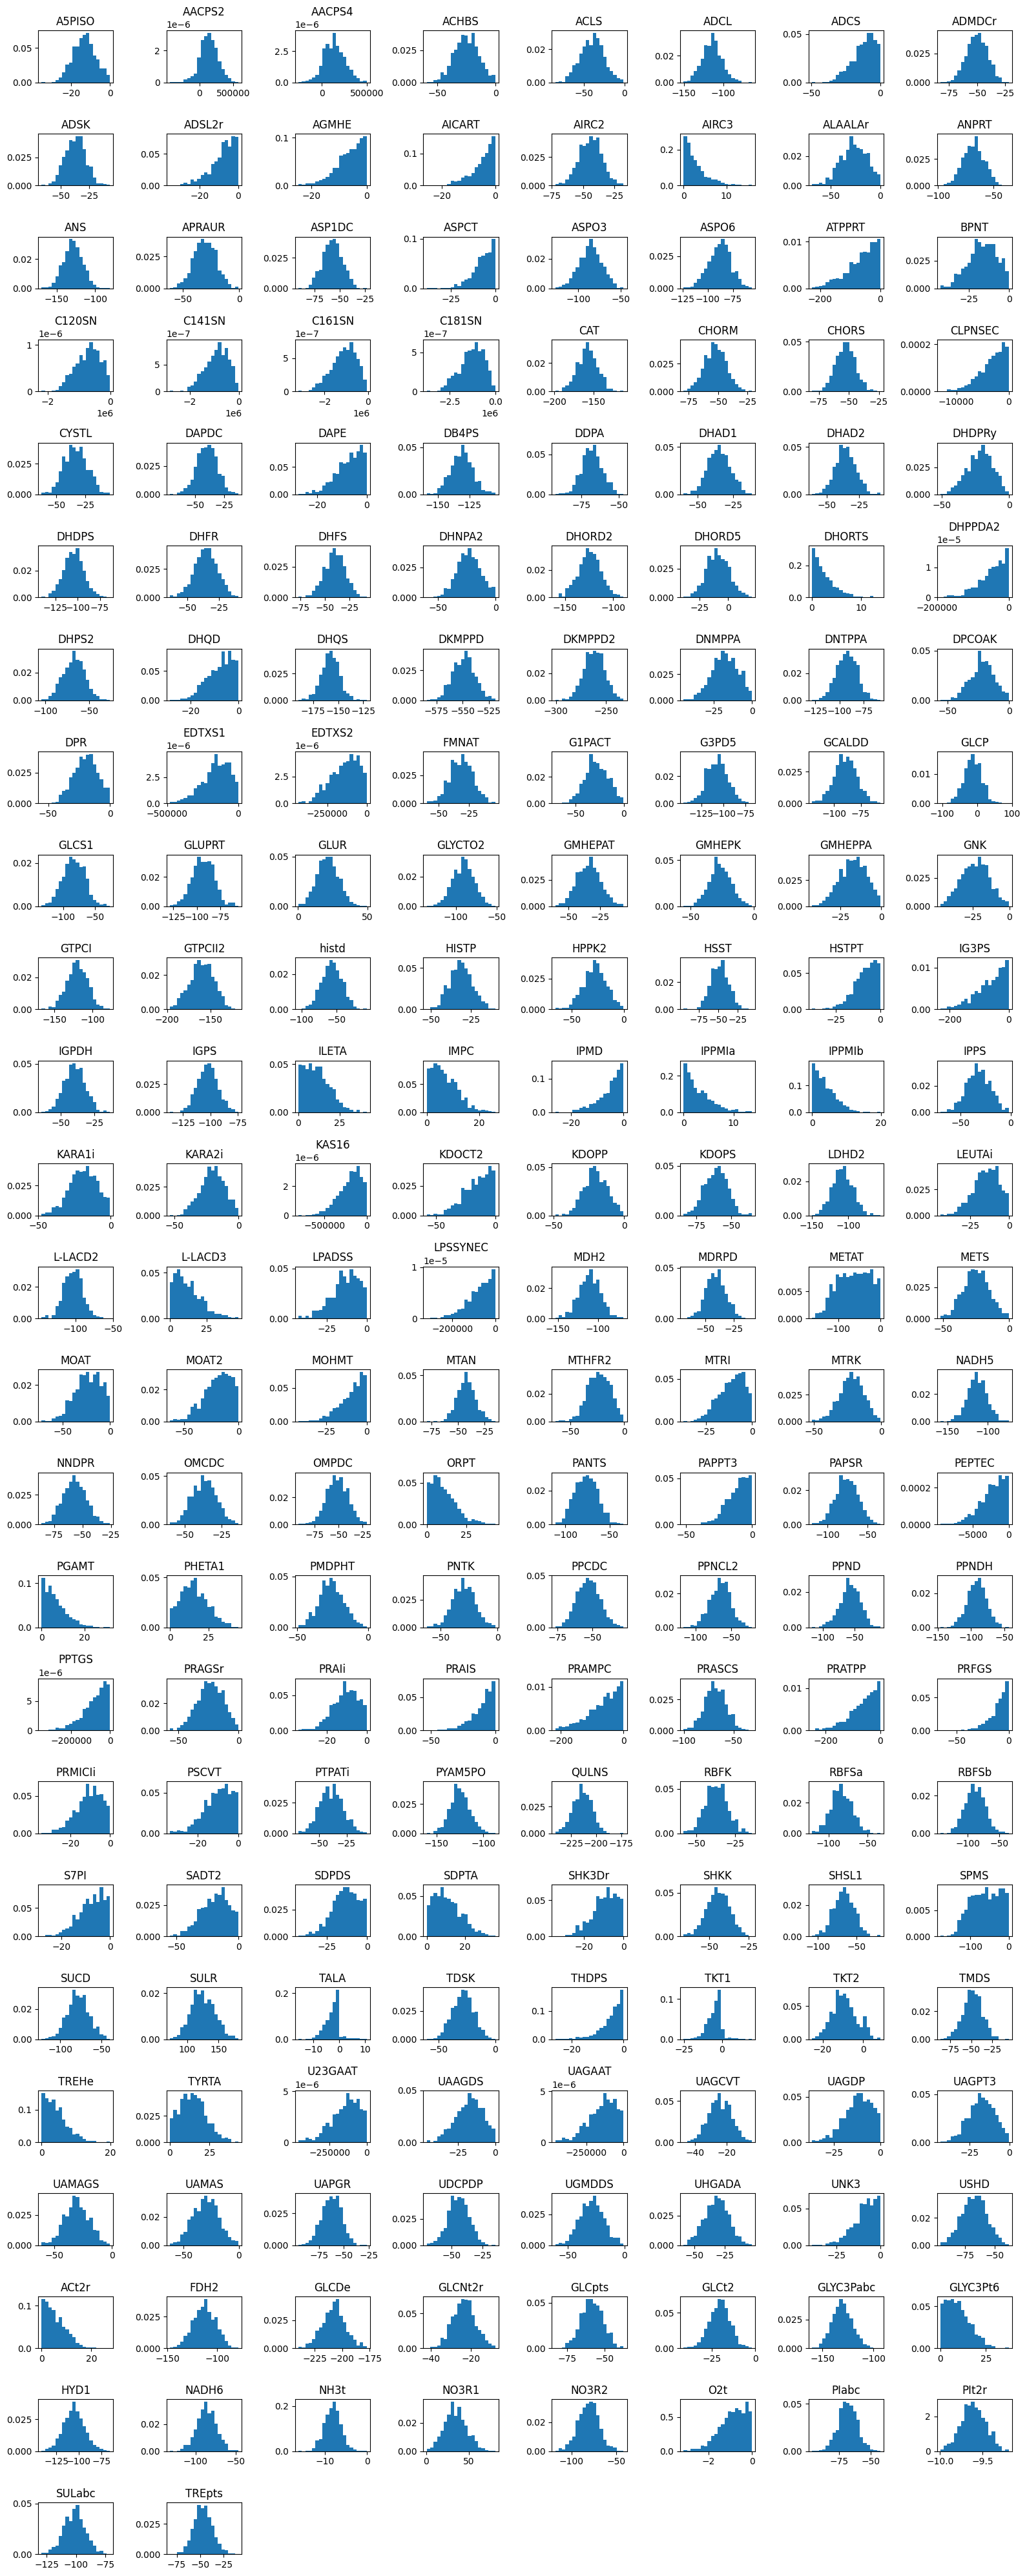

In [27]:
plot_samples(result.samples)

In [20]:
# Now repeat the process for Acetate condition
tmodel_ace = setup_model(CONDITIONS[1], mets_tva=None)

['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown metabolite 'pi[c]' created
unknown metabolite '5dglcn[c]' created
unknown metabolite 'ru5p-D

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


adphep-LD_c NOTHING DONE!
agm_c NOTHING DONE!
ptrc_c NOTHING DONE!
urea_c NOTHING DONE!
hcys-L_c NOTHING DONE!
rhcys_c NOTHING DONE!
10fthf_c NOTHING DONE!
fprica_c NOTHING DONE!
thf_c NOTHING DONE!
air_c NOTHING DONE!
5caiz_c NOTHING DONE!
5aizc_c NOTHING DONE!
ala-D_c NOTHING DONE!
alaala_c NOTHING DONE!
ala-L_c NOTHING DONE!
pydx5p_c NOTHING DONE!
pyam5p_c NOTHING DONE!
glyald_c NOTHING DONE!
glyc_c NOTHING DONE!
pacald_c NOTHING DONE!
pac_c NOTHING DONE!
alltt_c NOTHING DONE!
urdglyc_c NOTHING DONE!
alltn_c NOTHING DONE!
altrn_c NOTHING DONE!
2ddglcn_c NOTHING DONE!
malt_c NOTHING DONE!
malttr_c NOTHING DONE!
glc-D_c NOTHING DONE!
maltttr_c NOTHING DONE!
maltpt_c NOTHING DONE!
malthx_c NOTHING DONE!
malthp_c NOTHING DONE!
acmanap_c NOTHING DONE!
8aonn_c NOTHING DONE!
amob_c NOTHING DONE!
dann_c NOTHING DONE!
2dmmq8_c NOTHING DONE!
mqn8_c NOTHING DONE!
4ampm_c NOTHING DONE!
for_c NOTHING DONE!
r5p_c NOTHING DONE!
anth_c NOTHING DONE!
pran_c NOTHING DONE!
pmcoa_c NOTHING DONE!
ap4a_c

In [21]:
# Apply thermodynamic variables and additional respiratory constraint
tmodel_ace.m = None
tmodel_ace.objective = tmodel_ace.reactions.biomass_EX
tmodel_ace.add_TFBA_variables(qnorm='sep_norm')

add_rq_constraint(tmodel_ace, "WT-Ace_I", INPUT_EXP_DATA)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
>>>>>> RQ: 0.98 (vCO2 = 15.7 / vO2 = -16.0) ERR: 0.32137831084665863


In [22]:
tmodel_ace.m.Params.TimeLimit = 20
tmodel_ace.m.optimize()

Set parameter TimeLimit to value 20
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  20
NonConvex  2

Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Optimize a model with 6728 rows, 5411 columns and 155075 nonzeros
Model fingerprint: 0xba1ea22a
Model has 1 quadratic constraint
Model has 300 simple general constraints
  300 ABS
Variable types: 4789 continuous, 622 integer (622 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e-02, 1e+06]
  RHS range        [2e-14, 1e+05]
Presolve removed 4032 rows and 3158 columns
Presolve time: 0.36s
Presolved: 2700 rows, 2254 columns, 119

In [24]:
tva_run_scenarios_one_model_mets(tmodel_ace, "ecoli", "WT_Ace", "../results/WT_Ace")

Set parameter MIPGap to value 0.001
Added 2dhglcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,0] (value -8.586595245029704)>)
Added nadh_c : <MVar ()>
array(<gurobi.Var ln_conc[0,1] (value -8.992498462059846)>)
Added glcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,2] (value -7.194092308513203)>)
Added nad_c : <MVar ()>
array(<gurobi.Var ln_conc[0,3] (value -3.9697998139756887)>)
Added nadph_c : <MVar ()>
array(<gurobi.Var ln_conc[0,4] (value -16.11809565095832)>)
Added nadp_c : <MVar ()>
array(<gurobi.Var ln_conc[0,5] (value -13.090209183556246)>)
Added 2dhguln_c : <MVar ()>
array(<gurobi.Var ln_conc[0,6] (value -16.11809565095832)>)
Added idon-L_c : <MVar ()>
array(<gurobi.Var ln_conc[0,7] (value -16.111238743215054)>)
Added o2_c : <MVar ()>
array(<gurobi.Var ln_conc[0,8] (value -9.210340371976182)>)
Added h2o_c : <MVar ()>
array(<gurobi.Var ln_conc[0,9] (value 0.0)>)
Added pi_c : <MVar ()>
array(<gurobi.Var ln_conc[0,10] (value -3.912023005428146)>)
Added 5dglcn_c : <MVar ()>
array(<gur

In [27]:
# Recreate model with met TVA applied
tmodel_ace = setup_model(CONDITIONS[1], "results/ecoli_WT_Ace_mets_objval.txt")

['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown metabolite 'pi[c]' created
unknown metabolite '5dglcn[c]' created
unknown metabolite 'ru5p-D

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

In [28]:
tmodel_ace.m = None
tmodel_ace.objective = tmodel_ace.reactions.biomass_EX
tmodel_ace.add_TFBA_variables(qnorm='sep_norm')

add_rq_constraint(tmodel_ace, "WT-Ace_I", INPUT_EXP_DATA)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
>>>>>> RQ: 0.98 (vCO2 = 15.7 / vO2 = -16.0) ERR: 0.32137831084665863


In [29]:
tfva_run_scenarios_one_model(tmodel_ace, "ecoli", "WT_Ace", "../results/WT_Ace/parallel")

0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [ ]:
# Save flux bounds from before and after the TFVA for Glc condition
completed_ids = save_flux_bounds_tfva(tmodel_ace, "results/ecoli_WT_Ace_fluxes_objval.txt", "results/bounds/ecoli_WT_Ace_bounds_after_tfva.csv")
save_flux_bounds_before_tfva(tmodel_ace, completed_ids, "results/bounds/ecoli_WT_Ace_bounds_before_tfva.csv")